In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.7.0
/device:GPU:0


In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20141, done.
remote: Counting objects: 100% (1961/1961), done.
remote: Compressing objects: 100% (1057/1057), done.
remote: Total 20141 (delta 906), reused 1586 (delta 593), pack-reused 18180
Receiving objects: 100% (20141/20141), 33.15 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (11000/11000), done.


In [3]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [4]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 204s 0us/step
Dataset downloaded and extracted!


In [5]:
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
len(foods_sorted)

101

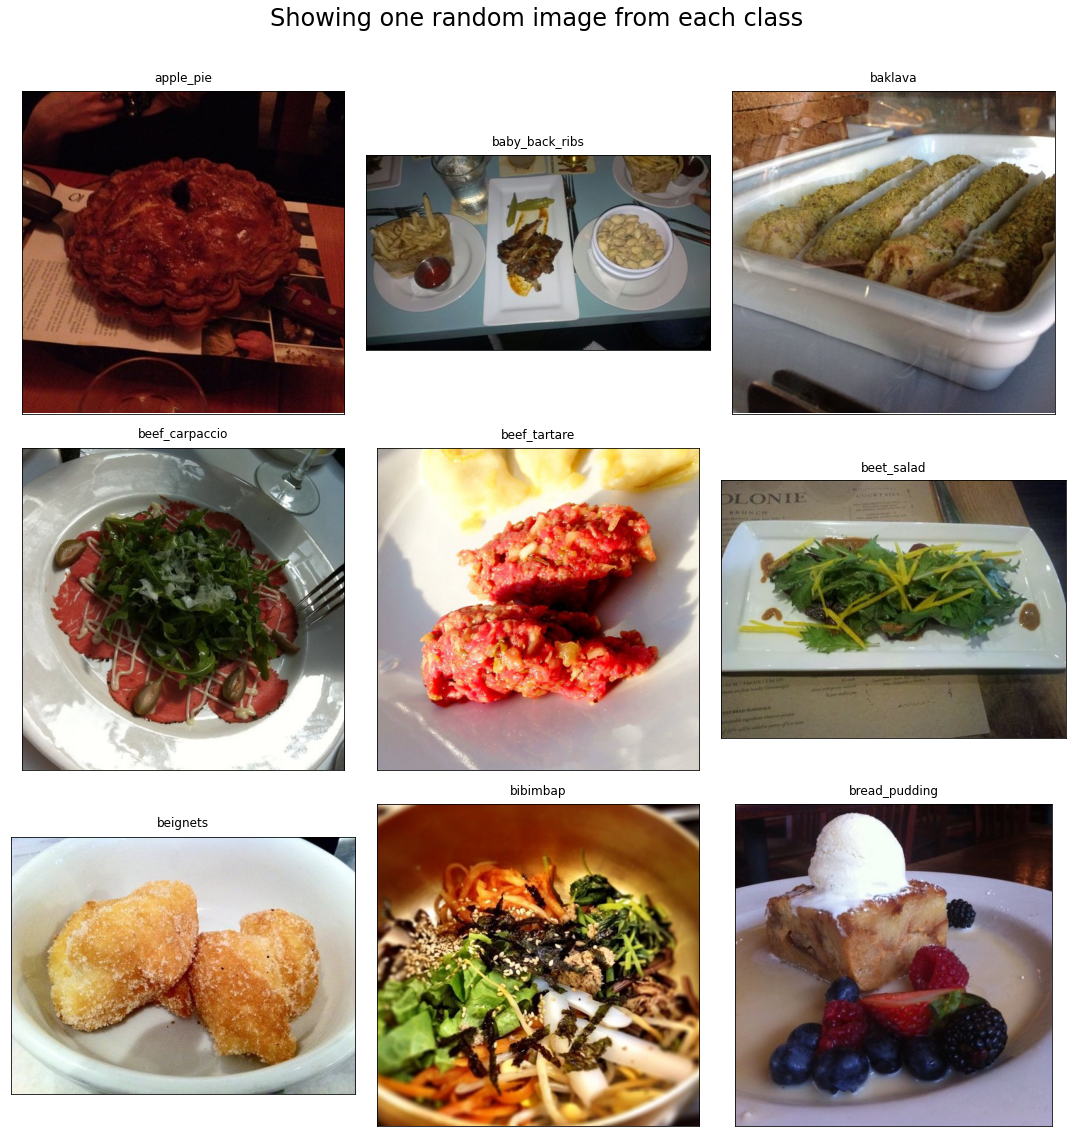

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(15,15))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [ ]:
# Helper method to split dataset into train,validation and test folders
def prepare_data(filepath, src,dest,nb):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')
  if os.path.exists(dest):
    rmtree(dest)
  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    t = 0
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
      t+=1
      if t>=nb:
        break
      
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train',750)

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test',20)

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [6]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [7]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
from tensorflow.keras import datasets, layers, models

In [11]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples,nb_layers,nb_filters,kernel_size):
  K.clear_session()

  img_width, img_height = 128, 128
  train_data_dir = 'food-101/train'
  validation_data_dir = 'food-101/test'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+"_"+str(nb_layers+1)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      validation_split=0.125,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='training')

  # validation_generator = test_datagen.flow_from_directory(
  #     validation_data_dir,
  #     target_size=(img_height, img_width),
  #     batch_size=batch_size,
  #     class_mode='categorical')
  
  validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


  # inception = InceptionV3(weights='imagenet', include_top=False)
  # x = inception.output
  # x = GlobalAveragePooling2D()(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.2)(x)

  # predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)


  model = models.Sequential()
  inp=keras.Input(shape=(128,128,3),name='inp')

  x = keras.layers.Conv2D(filters=nb_filters,kernel_size=(kernel_size,kernel_size),padding="same",activation='relu')(inp)
  x = keras.layers.MaxPool2D()(x)

  for i in range(nb_layers):
    x = keras.layers.Conv2D(filters=nb_filters,kernel_size=(kernel_size,kernel_size),padding="same",activation='relu')(x)
    x = keras.layers.MaxPool2D()(x)


  x = keras.layers.Flatten()(x)
  
  x = keras.layers.Dense(128,activation='relu')(x)
  model.add(Dropout(0.24))
  output_value = keras.layers.Dense(n_classes,activation='softmax')(x)


  # model = models.Sequential()
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=(32, 32, 3)))
  # model.add(layers.MaxPooling2D((2, 2)))

  # for i in range(3):
  #   model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
  #   model.add(layers.MaxPooling2D((2, 2)))
  #   print(model.summary())

  # model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  # model.add(layers.Flatten())
  # # model.add(layers.Dense(64, activation='relu'))
  
  # model.add(layers.Dense(3,activation='softmax'))

  model = keras.Model(inputs=inp, outputs=output_value)
  print(model.summary())
  # model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=validation_generator.samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 2
food_list = pick_n_random_classes(n)
# food_list = ['seaweed_salad','waffles','red_velvet_cake','cup_cakes','pizza','spaghetti_carbonara','hamburger','ice_cream','macarons','mussels']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

These are the randomly picked food classes we will be training the model on...
 ['french_toast', 'fried_rice']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into french_toast
Copying images into fried_rice


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
1500


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into french_toast
Copying images into fried_rice


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
500


In [12]:
# Train the model with data from 4 classes
n_classes = 101
epochs = 10
nb_layers =3
nb_filters = 64
kernel_size =5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_10 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples,nb_layers,nb_filters,kernel_size)
print(class_map_10)

Found 66357 images belonging to 101 classes.
Found 9393 images belonging to 101 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                      

In [ ]:
food_list = ['seaweed_salad','waffles','red_velvet_cake','cup_cakes','pizza','spaghetti_carbonara','hamburger','ice_cream','macarons','mussels']

In [13]:
img_width, img_height = 128, 128
validation_data_dir = 'food-101/test'
batch_size=16

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 25250 images belonging to 101 classes.


In [14]:
K.clear_session()
model_best = load_model('bestmodel_101class.hdf5',compile = False)

In [15]:
model_best.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_best.evaluate(test_generator)

1579/1579 [==============================] - 146s 92ms/step - loss: 4.6152 - accuracy: 0.0099


[4.615212917327881, 0.009900989942252636]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


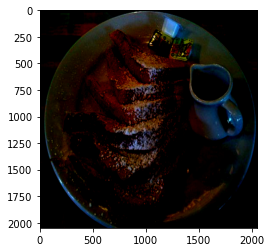

In [ ]:
x= test_generator.next()
# for i in range(0,16):
image = x[0]
# image = np.asarray(image)
# plt.imshow(image)
print(image[0].shape)
plt.imshow(image[0])
plt.show()

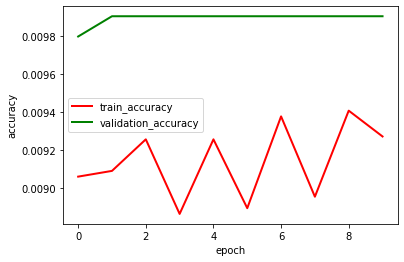

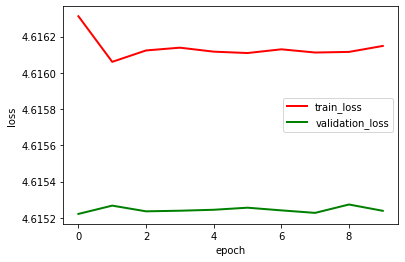

In [17]:
def plot_accuracy(history,title):
    plt.plot(history.history['accuracy'],c='r',linewidth=2) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy'],c='g',linewidth=2) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.plot(history.history['loss'],c='r',linewidth=2)
    plt.plot(history.history['val_loss'],c='g',linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101')
plot_loss(history,'FOOD101')

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 111 ms, sys: 6.93 ms, total: 118 ms
Wall time: 120 ms


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/examples/community/en/multi_class_classification/images/'
images.append(imagepath+'samosa.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

FileNotFoundError: ignored